In [12]:
# Import statements
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.preprocessing import label_binarize

In [13]:
# Details about the cuda device
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0)} bytes")
    print(f"Memory Cached: {torch.cuda.memory_reserved(0)} bytes")
    print(f"Total Memory: {torch.cuda.get_device_properties(0).total_memory} bytes")
else:
    print("CUDA is not available. Using CPU instead.")

True
Using device: cuda
Device name: NVIDIA GeForce RTX 3060 Laptop GPU
Memory Allocated: 227981824 bytes
Memory Cached: 241172480 bytes
Total Memory: 6441926656 bytes


In [14]:
class ImageDataset(Dataset):
    def __init__(self, txt_loc, transform=None):
        print("Initializing image dataset.")
        self.image_labels = []
        self.image_paths = self.find_full_paths(txt_loc)
        self.transform = transform
        print(f"Total images found: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path, label = self.image_paths[index]
        try:
            image = Image.open(img_path)
            if self.transform:
                image = self.transform(image)
            # print(f"Loaded image {index + 1}/{len(self.image_paths)}: {img_path}")
            return image, torch.tensor(label, dtype=torch.long)
        except IOError as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None

    def find_file_by_suffix(self, directory, filename_suffix):
        for root, dirs, files in os.walk(directory):
            for filename in files:
                if filename.endswith(filename_suffix):
                    return os.path.join(root, filename)
        return None

    def find_full_paths(self, txt_loc):
        data_dirs = os.listdir("color/")
        final_paths = []
        with open(txt_loc, 'r') as infile:
            lines = [line.strip() for line in infile.readlines()]
        
        for line in lines:
            parts = line.rsplit(' ', 1) 
            filename = parts[0]
            label = int(parts[1]) - 1
            directory_index = label
            file_location = f'color/{data_dirs[directory_index]}/'
            full_path = self.find_file_by_suffix(file_location, filename)
            if full_path:
                final_paths.append((full_path, label))
            else:
                print(f"File not found: {filename} in {file_location}")
        return final_paths


In [15]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=31):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2, groups=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1, groups=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
model = AlexNet().to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
    (5): ReLU(inplace=True)
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (11): ReLU(inplace=True)
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=

In [16]:
transform = transforms.Compose([
    transforms.CenterCrop(227), #alexnet size
    transforms.ToTensor(),
])

train_dataset = ImageDataset(txt_loc='./train.txt', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

print(len(train_dataset))

test_dataset = ImageDataset(txt_loc='./test.txt', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=0)

print(len(test_dataset))


Initializing image dataset.
Total images found: 34011
34011
Initializing image dataset.
Total images found: 8498
8498


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
model.train()
for epoch in range(15):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for i, (inputs, labels) in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loop.set_description(f'Epoch {epoch + 1}')
        loop.set_postfix(loss=loss.item())


Epoch 15: 100%|██████████| 1063/1063 [02:18<00:00,  7.65it/s, loss=0.32] 


Accuracy: 88.49%
F1 Score: 0.88


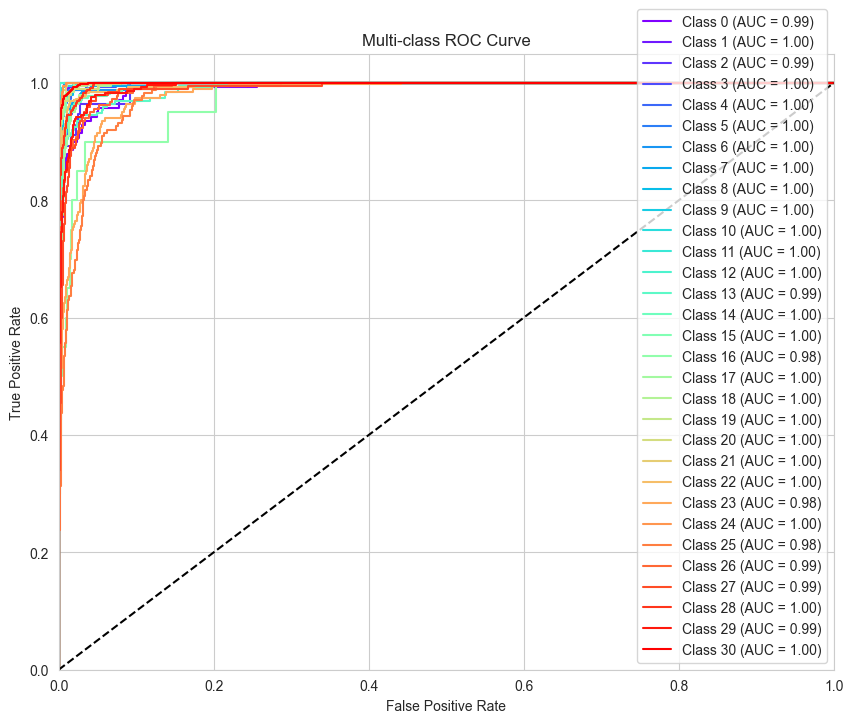

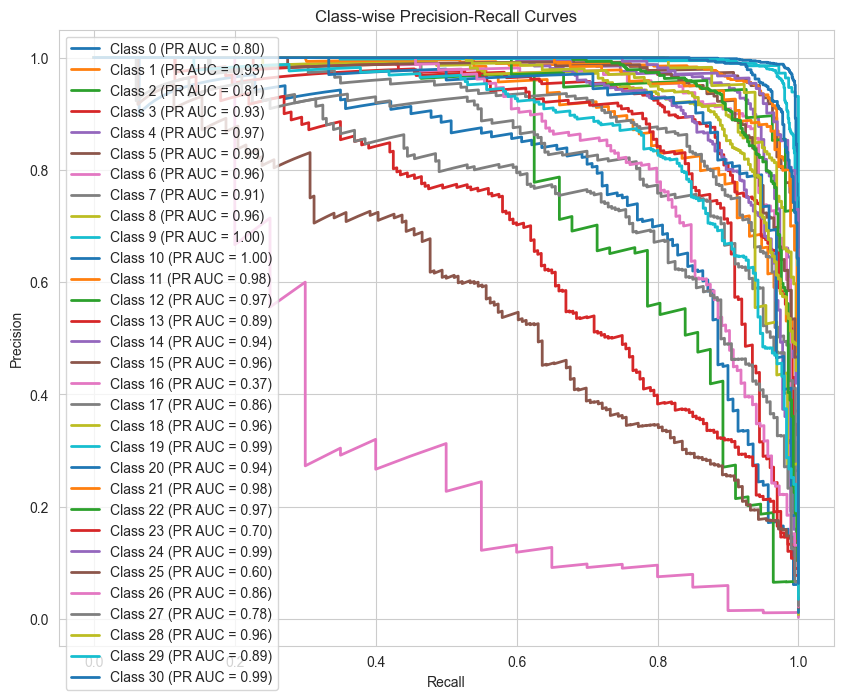

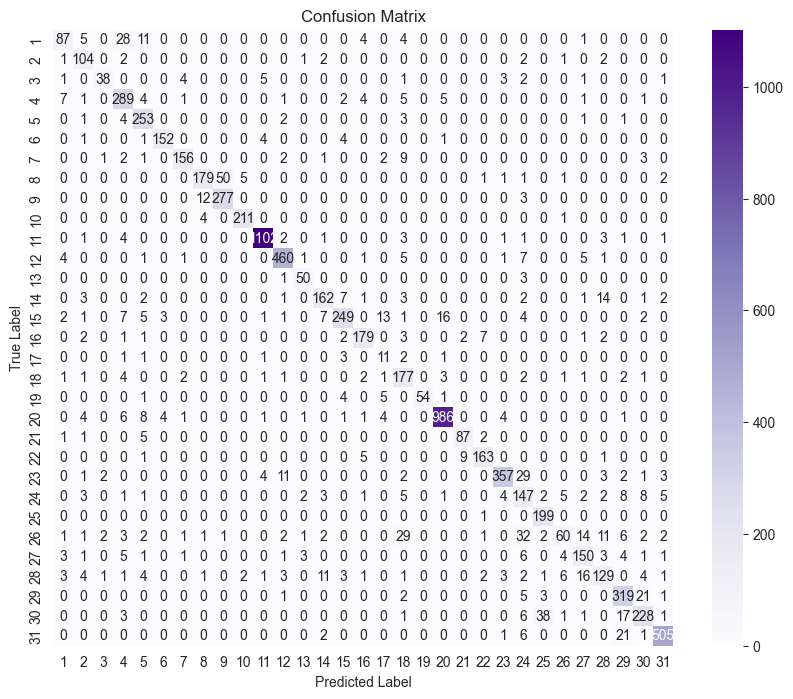

In [25]:
import torch.nn.functional as F

classes = [f'{i}' for i in range(1, 32)]

def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Purples, fmt='g', 
                 xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
def plot_roc_curve_multiclass(num_classes, true_labels, probabilities):
    true_labels = label_binarize(true_labels, classes=[i for i in range(num_classes)])
    n_classes = true_labels.shape[1]
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    colors = iter(plt.cm.rainbow(np.linspace(0, 1, n_classes)))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=next(colors), label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.show()




def plot_precision_recall(labels, probabilities, num_classes):
    labels = label_binarize(labels, classes=[i for i in range(num_classes)])
    
    precision = dict()
    recall = dict()
    pr_auc = dict()

    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(labels[:, i], probabilities[:, i])
        pr_auc[i] = auc(recall[i], precision[i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (PR AUC = {pr_auc[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Class-wise Precision-Recall Curves')
    plt.legend(loc="best")
    plt.show()
    
def evaluate_model(model, device, data_loader, classes):
    model.eval()
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []
    probabilities_list = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            probabilities = F.softmax(outputs, dim=1)
            probabilities_list.append(probabilities.cpu())
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    print(f'Accuracy: {accuracy:.2f}%')
    print(f'F1 Score: {f1:.2f}')

    probabilities = torch.cat(probabilities_list, dim=0)
    true_labels = torch.tensor(true_labels)
    
    return true_labels, predicted_labels, probabilities
    
    
classes = [i for i in range(1, 32)]
true_labels, predicted_labels, probabilities = evaluate_model(model, device, test_loader, classes)
plot_roc_curve_multiclass(len(classes), true_labels, probabilities)
plot_precision_recall(true_labels, probabilities, num_classes=31)
plot_confusion_matrix(true_labels, predicted_labels, classes)